In [1]:
%matplotlib inline
import cv2
from scipy import ndimage
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 114
plt.rcParams['savefig.dpi'] = 114

Импорт кадра из датасета


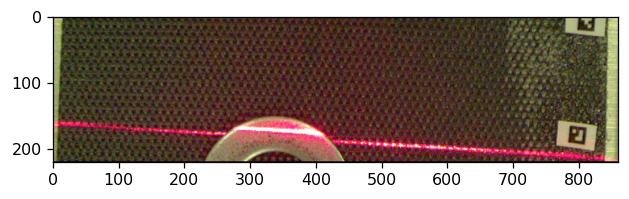

In [2]:
img = cv2.imread("./dataset/img_scan50.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Подготовка изображения


In [3]:
def prepare_image(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 2))
    img_filtered = cv2.bitwise_and(
        img,
        img,
        mask=cv2.inRange(
            img,
            np.array([150, 0, 0]),
            np.array([255, 255, 255]),
        ),
    )
    img_eroded = cv2.erode(img_filtered, kernel)
    img_dilated = cv2.dilate(img_eroded, kernel)

    return img_dilated, img_eroded, img_filtered

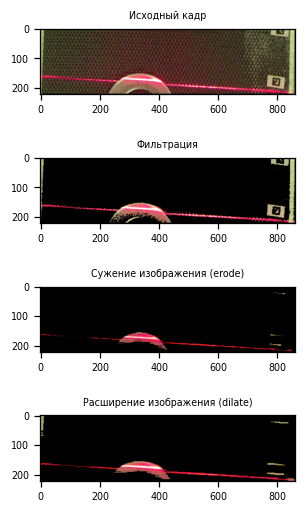

In [4]:
img_dilated, img_eroded, img_filtered = prepare_image(img)
img_prepared = img_dilated

fig, axs = plt.subplots(4, 1)
fig.tight_layout(pad=2.0)
ax_prepared, ax_threshold, ax_laser, ax_laser_smooth = axs

ax_prepared.imshow(img)
ax_prepared.set_title("Исходный кадр", fontsize=6)
ax_prepared.tick_params(axis='x', labelsize=6)
ax_prepared.tick_params(axis='y', labelsize=6)

ax_threshold.imshow(img_filtered)
ax_threshold.set_title("Фильтрация", fontsize=6)
ax_threshold.tick_params(axis='x', labelsize=6)
ax_threshold.tick_params(axis='y', labelsize=6)

ax_laser.imshow(img_eroded)
ax_laser.set_title("Сужение изображения (erode)", fontsize=6)
ax_laser.tick_params(axis='x', labelsize=6)
ax_laser.tick_params(axis='y', labelsize=6)

ax_laser_smooth.imshow(img_dilated)
ax_laser_smooth.set_title("Расширение изображения (dilate)", fontsize=6)
ax_laser_smooth.tick_params(axis='x', labelsize=6)
ax_laser_smooth.tick_params(axis='y', labelsize=6)

Расчет нормализованной интенсивности одной вертикальной строки изображения


In [5]:
def calc_intense_norm(line: np.ndarray[np.uint8], y_min=0):
    data = np.array([[0]] * y_min + list(line[y_min:]))
    minimum, delta = np.min(data), np.max(data) - np.min(data) or 1
    return np.array([(x - minimum) / delta for x in data])

In [6]:
def calc_intense_accurate(line: np.ndarray[np.uint8]):
    def f_gauss(
        x: np.ndarray, a: float, mu: float, sigma: float, b: float
    ) -> np.ndarray:
        return (a / sigma / np.sqrt(2 * np.pi)) * np.exp(
            -0.5 * ((x - mu) / sigma) ** 2
        ) + b

    y = calc_intense_norm(line)

    xmin, xmax = 0, len(y)
    x = np.linspace(xmin, xmax, xmax - xmin)
    i_max = y.argmax()
    ymax = y[i_max]
    mu0 = x[i_max]
    b0 = y.mean()

    i_half = np.argmax(y >= (ymax + b0) / 2)
    sigma0 = (mu0 - x[i_half]) / np.sqrt(2 * np.log((ymax - b0) / (y[i_half] - b0)))

    if np.isnan(sigma0):
        return y

    a0 = (ymax - b0) * sigma0 * np.sqrt(2 * np.pi)
    a0 = sigma0 * np.sqrt(2 * np.pi)
    p0 = a0, mu0, sigma0, b0

    mu0 = x[i_max]  # y.mean()
    a0 = (y - y.min()) / (y.max() - y.min()) * sigma0 / np.sqrt(2 * np.pi)
    b0 = y.mean()
    sigma0 = sum([(x**2) for x in y]) / len(y)
    sigma0 = (mu0 - x[i_half]) / np.sqrt(2 * np.log((ymax - b0) / (y[i_half] - b0)))
    p0 = a0, mu0, sigma0, b0

    return f_gauss(x, *p0)

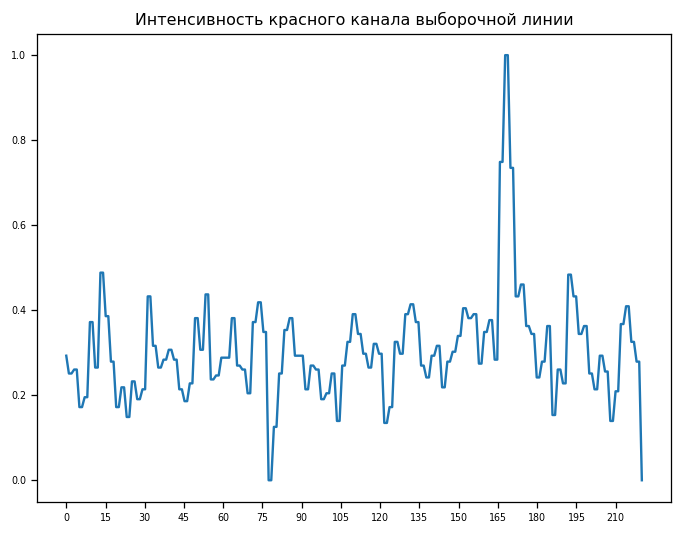

In [7]:
red_line, _, _ = cv2.split(img[:, 100:101])
y_orig = calc_intense_norm(red_line)
y = np.linspace(0, len(y_orig), len(y_orig))

fig, ax_prepared = plt.subplots(1, 1)
fig.tight_layout(pad=1.5)

ax_prepared.plot(y, y_orig)
ax_prepared.set_title("Интенсивность красного канала выборочной линии", fontsize=10)
ax_prepared.get_xaxis().set_ticks(np.arange(0, len(y), 15))
ax_prepared.tick_params(axis='x', labelsize=6)
ax_prepared.tick_params(axis='y', labelsize=6)
pass

In [8]:
from scipy.signal import medfilt


def generate_laser_coords(f, *, img, intense_delta_thr=0.5):
    _, width, _ = img.shape
    return tuple(f(x, img=img, intense_delta_thr=intense_delta_thr) for x in range(width))


def generate_smooth_coords(coords, window_size=7):
    return medfilt(coords, window_size)


def fill_image(img, rgb_color, coords):
    for x, y in enumerate(coords):
        if y >= 0:
            img[y, x] = rgb_color
    return img


def create_blank_image(height, width):
    img = np.zeros((height, width, 3), np.uint8)
    img[::] = (255, 255, 255)
    return img

In [9]:
def f(x, *, img, intense_delta_thr=0.5):
    # Извлечь вертикальную линию по x
    vert_line = img[:, x : x + 1]
    # Выделить красный канал
    r_channel = cv2.split(vert_line)[0]
    # Расчитать нормализованную интенсивность
    values = calc_intense_norm(r_channel)
    # Вернуть пик интенсивности
    y = np.argmax(values)
    return y if (np.max(values) - np.mean(values)) > intense_delta_thr else -1

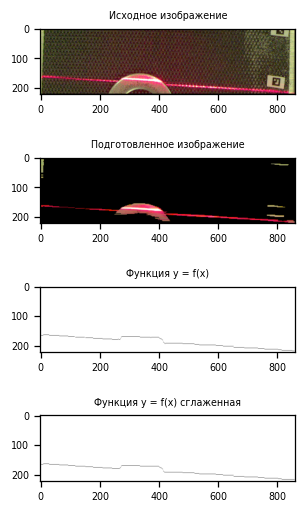

In [10]:
fig, axs = plt.subplots(4, 1)
fig.tight_layout(pad=2.0)
ax_orig, ax_prepared, ax_laser, ax_laser_smooth = axs

ax_orig.imshow(img)
ax_orig.set_title("Исходное изображение", fontsize=6)
ax_orig.tick_params(axis='x', labelsize=6)
ax_orig.tick_params(axis='y', labelsize=6)

ax_prepared.imshow(img_prepared)
ax_prepared.set_title("Подготовленное изображение", fontsize=6)
# ax_orig.get_xaxis().set_ticks(np.arange(0, len(y), 100))
ax_prepared.tick_params(axis='x', labelsize=6)
ax_prepared.tick_params(axis='y', labelsize=6)

height, width, _ = img.shape
ax_laser.imshow(
    fill_image(
        create_blank_image(height, width),
        (0, 0, 0),
        generate_laser_coords(f, img=img_prepared, intense_delta_thr=0.5),
    )
)
ax_laser.set_title("Функция y = f(x)", fontsize=6)
ax_laser.tick_params(axis='x', labelsize=6)
ax_laser.tick_params(axis='y', labelsize=6)

ax_laser_smooth.imshow(
    fill_image(
        create_blank_image(height, width),
        (0, 0, 0),
        generate_smooth_coords(
            generate_laser_coords(f, img=img_prepared, intense_delta_thr=0.5),
            window_size=21,
        ),
    )
)
ax_laser_smooth.set_title("Функция y = f(x) сглаженная", fontsize=6)
ax_laser_smooth.tick_params(axis='x', labelsize=6)
ax_laser_smooth.tick_params(axis='y', labelsize=6)
pass

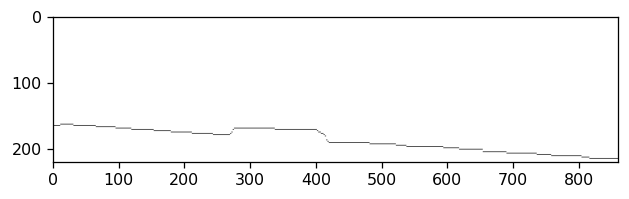

In [11]:
def process(img):
    img_prepared, *_ = prepare_image(img)
    return fill_image(
        create_blank_image(height, width),
        (0, 0, 0),
        generate_smooth_coords(
            generate_laser_coords(f, img=img_prepared, intense_delta_thr=0.6), window_size=21
        ),
    )


plt.imshow(process(img))

In [12]:
import os
import re

files = os.listdir("./dataset")
tpls = []
for file in files:
    m = re.match("img_scan(\d+)", file)
    tpls += [(int(m.group(1)), m.group(0))]

filenames = [filename for _, filename in sorted(tpls)]

In [ ]:
writer = cv2.VideoWriter()
writer.open("./output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (860, 440))
for filename in filenames:
    orig_frame = cv2.imread(f"./dataset/{filename}.png")
    frame = cv2.vconcat(
        [orig_frame, process(cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB))]
    )
    writer.write(frame)
writer.release()

KeyboardInterrupt: 